# Часть 4: Финальное обучение и сохранение моделей

Этот ноутбук содержит:
- Финальное обучение выбранной модели на train+val
- Оценка качества на test set
- Анализ ошибок (residuals, worst intervals)
- Feature importance
- Сохранение модели




## Загрузка результатов тюнинга

Этот ноутбук требует результаты тюнинга из `03_model_tuning.ipynb`:


In [1]:
import joblib
xgb_tuned = joblib.load("models/metadata/xgb_tuned_results.joblib")

best_params_by_h = {h: xgb_tuned[h]["best_params"] for h in xgb_tuned.keys()}

In [27]:
# import joblib
# lgbm_tuned = joblib.load("artifacts/metadata/lgbm_tuned_results.joblib")

# best_params_by_h = {h: lgbm_tuned[h]["best_params"] for h in lgbm_tuned.keys()}


In [7]:
best_params_by_h


{1: {'subsample': 0.6,
  'reg_lambda': 1.0,
  'reg_alpha': 0.001,
  'n_estimators': 500,
  'min_child_weight': 5,
  'max_depth': 6,
  'learning_rate': 0.01,
  'gamma': 1.0,
  'colsample_bytree': 0.8},
 24: {'subsample': 0.6,
  'reg_lambda': 2.0,
  'reg_alpha': 0.1,
  'n_estimators': 500,
  'min_child_weight': 7,
  'max_depth': 3,
  'learning_rate': 0.01,
  'gamma': 0.1,
  'colsample_bytree': 0.6},
 168: {'subsample': 0.6,
  'reg_lambda': 1.0,
  'reg_alpha': 0.001,
  'n_estimators': 500,
  'min_child_weight': 5,
  'max_depth': 6,
  'learning_rate': 0.01,
  'gamma': 1.0,
  'colsample_bytree': 0.8}}

Лучшая модель XGBoost

In [9]:
# === ИНИЦИАЛИЗАЦИЯ DATAMANAGER ===
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from src.data.data_manager import DataManager
from src.data.feature_builder import build_targets_multi_horizon, time_split_Xy

# Создаём менеджер данных
try:
    dm  # Если уже создан в предыдущем ноутбуке
    X, y  # Если уже загружены
    targets  # Если уже созданы
    best_params_by_h  # Если уже есть из тюнинга
except NameError:
    dm = DataManager()
    X, y = dm.get_ml_features_view()
    targets = build_targets_multi_horizon(y, horizons=(1, 24, 168))
    # best_params_by_h нужно загрузить из результатов тюнинга
    print("Необходимо загрузить best_params_by_h из 03_model_tuning.ipynb")

print(f"Данные готовы для финального обучения: X.shape={X.shape}")

Данные готовы для финального обучения: X.shape=(34896, 34)


In [11]:
import joblib
splits = joblib.load("models/metadata/splits.joblib")



In [13]:
def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred) + eps)
    
    return float(100.0 * np.mean(2.0 * numerator / denominator))

In [15]:
import time
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


def fit_final_xgb_and_test_v3(
    splits: dict,
    xgb_tuned: dict,
    horizons=(1, 24, 168),
    random_state=42,
    n_jobs=1,
    verbosity=0,
    store_models=True
):
    rows = {}
    final_models = {} if store_models else None

    meta = {
        "final_model": "XGBoost",
        "strategy": "direct (one model per horizon)",
        "final_fit": "train+val",
        "final_eval": "test",
        "metrics": ["MAE", "RMSE", "sMAPE"],
        "horizons": list(horizons),
    }

    for h in horizons:
        if h not in splits:
            raise KeyError(f"splits не содержит горизонт h={h}. Доступно: {list(splits.keys())}")

        if h not in xgb_tuned or "best_params" not in xgb_tuned[h]:
            raise KeyError(f"xgb_tuned не содержит best_params для h={h}")

        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]

        X_trainval = pd.concat([X_train, X_val], axis=0)
        y_trainval = pd.concat([y_train, y_val], axis=0)

        best_params = dict(xgb_tuned[h]["best_params"])
        best_params.pop("random_state", None)
        best_params.pop("n_jobs", None)
        best_params.pop("verbosity", None)
        best_params.pop("objective", None)
        best_params.pop("tree_method", None)

        model = XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            random_state=random_state,
            n_jobs=n_jobs,
            verbosity=verbosity,
            **best_params
        )

        t0 = time.time()
        model.fit(X_trainval, y_trainval)
        training_time_sec = time.time() - t0

        t0 = time.time()
        y_pred_test = model.predict(X_test)
        inference_time_sec = time.time() - t0

        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        test_smape = smape(y_test.values, y_pred_test)

        val_mae = xgb_tuned[h].get("val_MAE", np.nan)
        val_rmse = xgb_tuned[h].get("val_RMSE", np.nan)
        val_smape = xgb_tuned[h].get("val_sMAPE_pct", np.nan)

        rows[h] = {
            "model": "XGBoost_final",
            "horizon": int(h),
            "val_MAE": float(val_mae) if pd.notna(val_mae) else np.nan,
            "val_RMSE": float(val_rmse) if pd.notna(val_rmse) else np.nan,
            "val_sMAPE_pct": float(val_smape) if pd.notna(val_smape) else np.nan,
            "test_MAE": float(test_mae),
            "test_RMSE": float(test_rmse),
            "test_sMAPE_pct": float(test_smape),
            "training_time_sec": training_time_sec,
            "inference_time_sec": inference_time_sec,
            "n_train": int(len(X_train)),
            "n_val": int(len(X_val)),
            "n_test": int(len(X_test)),
            "best_params": best_params,
        }

        if store_models:
            final_models[h] = model

        print(
            f"[FINAL XGB] h={h}: "
            f"test_MAE={test_mae:.2f}, test_RMSE={test_rmse:.2f}, test_sMAPE={test_smape:.2f}% | "
            f"fit={training_time_sec:.1f}s, infer={inference_time_sec:.3f}s"
        )

    summary_df = (
        pd.DataFrame(list(rows.values()))
        .sort_values("horizon")
        .reset_index(drop=True)
    )

    return {
        "meta": meta,
        "summary": summary_df,
        "final_models": final_models,
    }


final_pack_xgb = fit_final_xgb_and_test_v3(splits, xgb_tuned)

final_pack_xgb["meta"]
final_pack_xgb["summary"]
final_pack_xgb["final_models"][1]

[FINAL XGB] h=1: test_MAE=102.56, test_RMSE=136.77, test_sMAPE=11.90% | fit=3.7s, infer=0.043s
[FINAL XGB] h=24: test_MAE=108.25, test_RMSE=144.76, test_sMAPE=12.47% | fit=1.4s, infer=0.019s
[FINAL XGB] h=168: test_MAE=106.51, test_RMSE=142.78, test_sMAPE=12.27% | fit=3.7s, infer=0.044s


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 


=== Error analysis (TEST): h=1 ===
h=1 | MAE=102.56, RMSE=136.77, bias(mean error)=-12.06
h=1 | median_AE=76.89, p90_AE=226.12, p95_AE=287.68


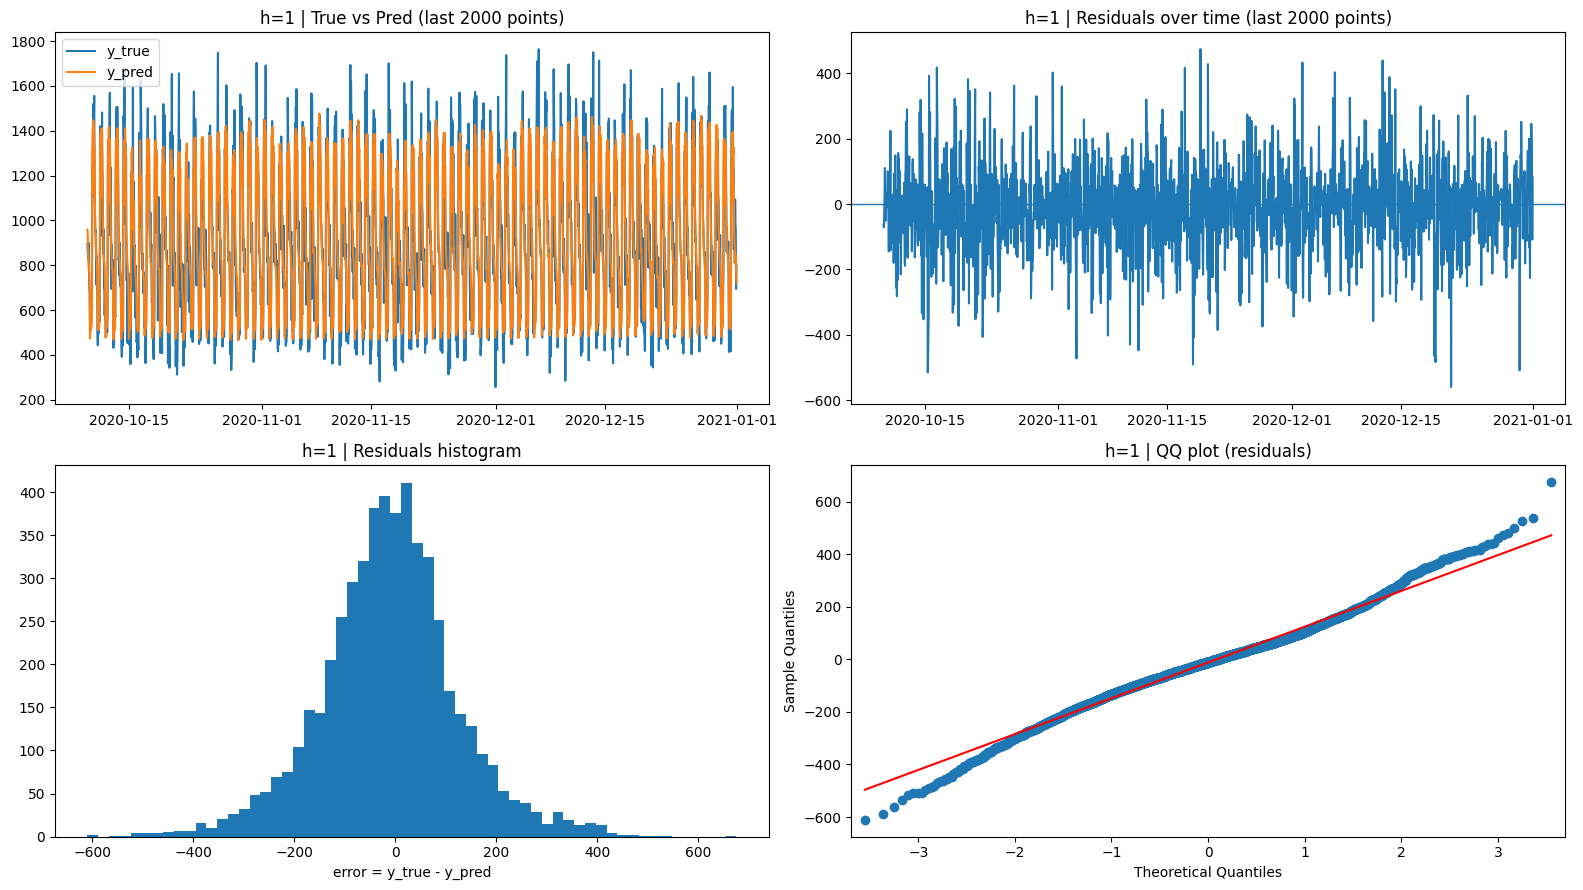

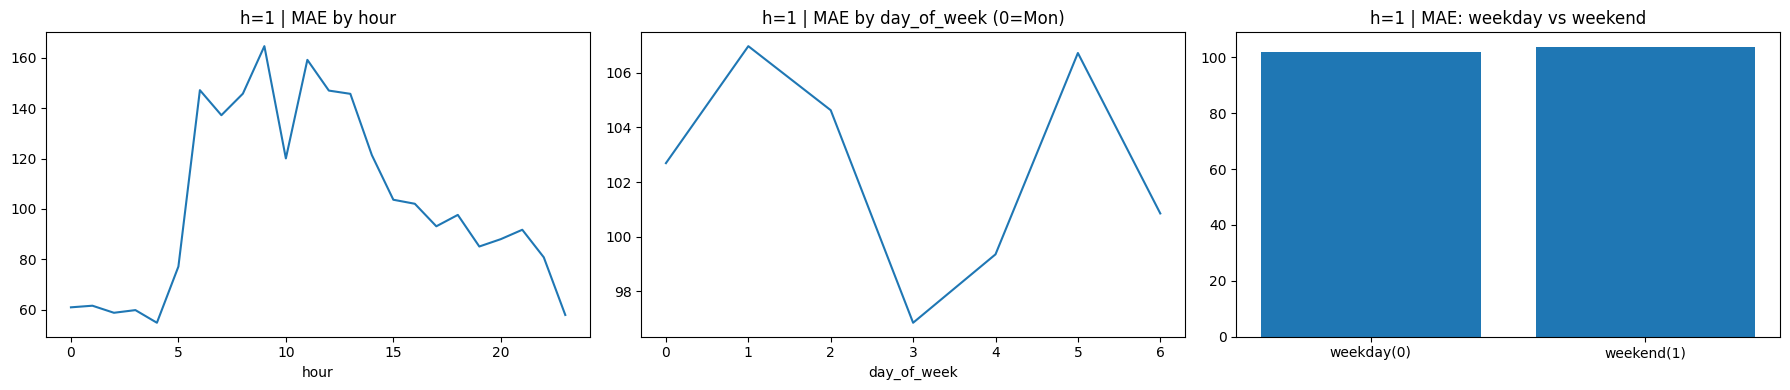


=== Error analysis (TEST): h=24 ===
h=24 | MAE=108.25, RMSE=144.76, bias(mean error)=-17.99
h=24 | median_AE=81.79, p90_AE=238.60, p95_AE=304.84


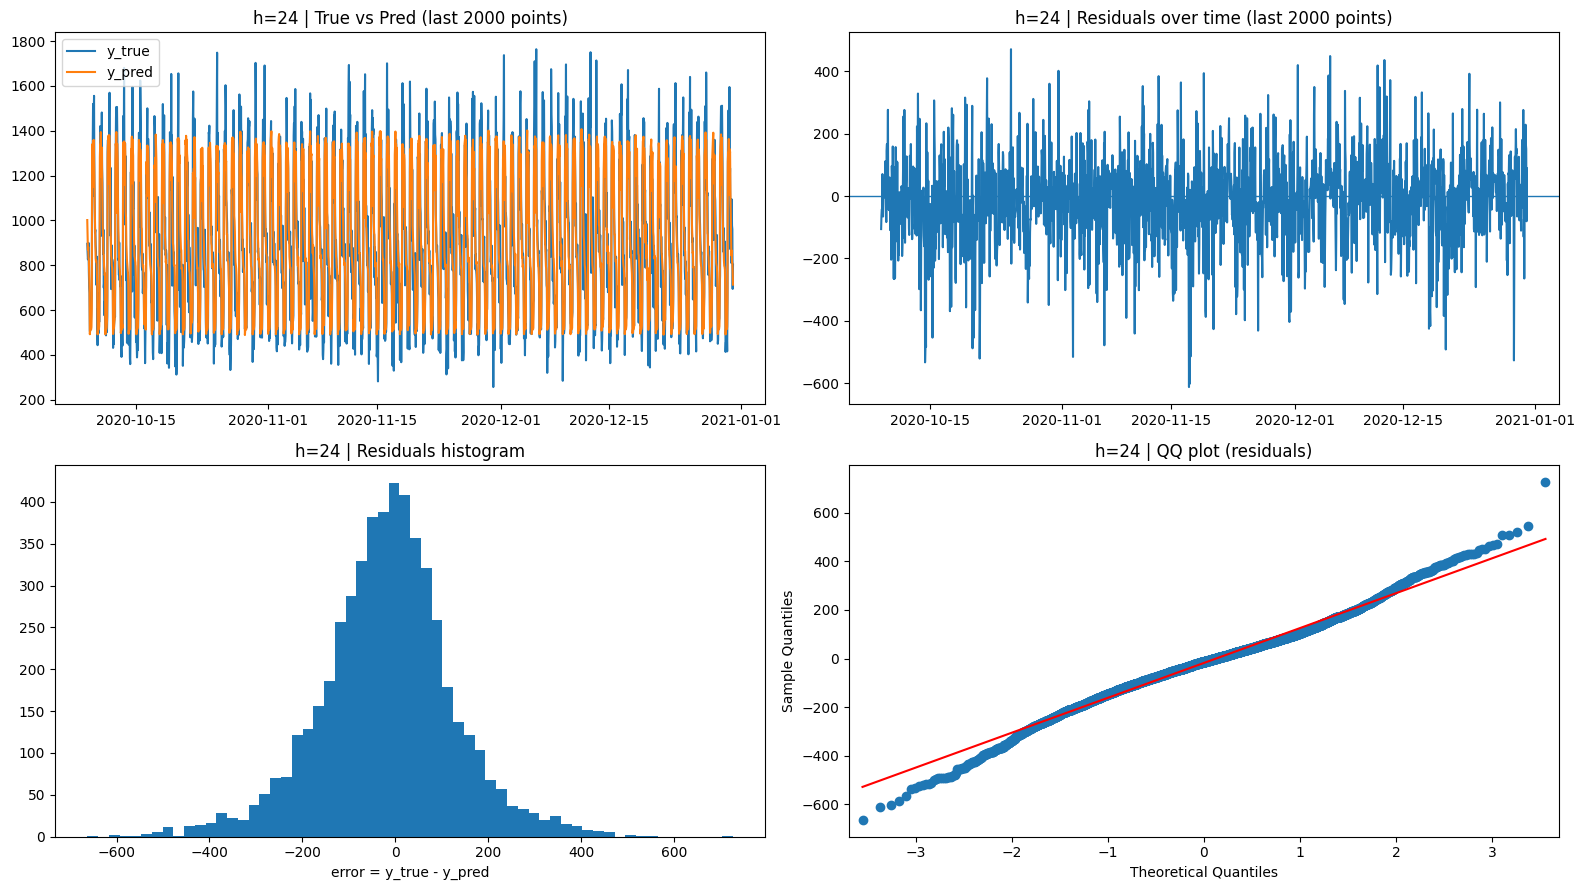

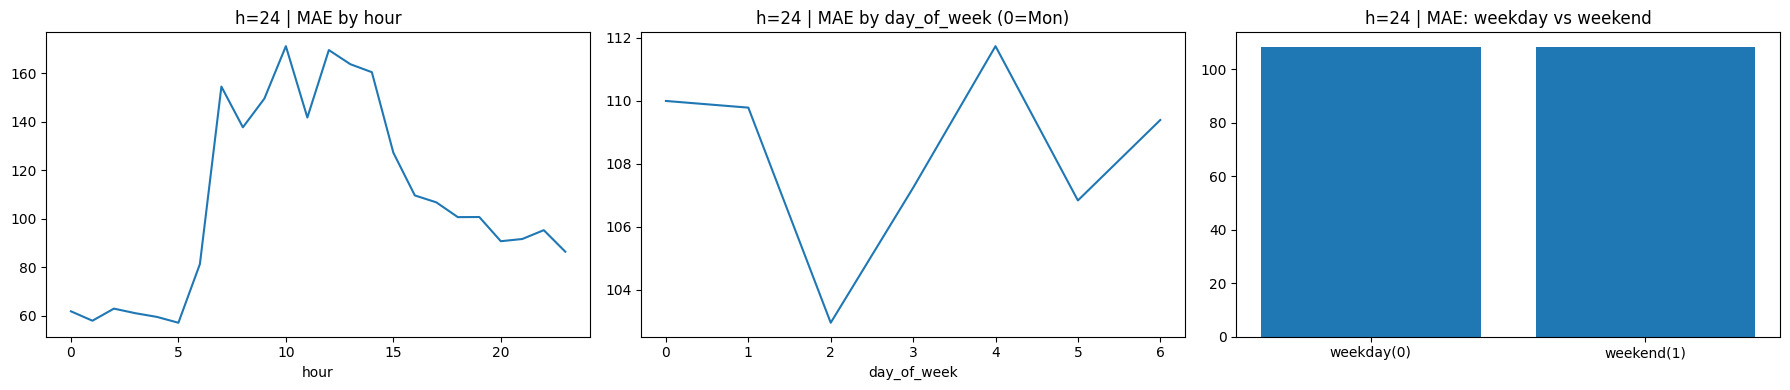


=== Error analysis (TEST): h=168 ===
h=168 | MAE=106.51, RMSE=142.78, bias(mean error)=-18.81
h=168 | median_AE=79.69, p90_AE=235.36, p95_AE=305.56


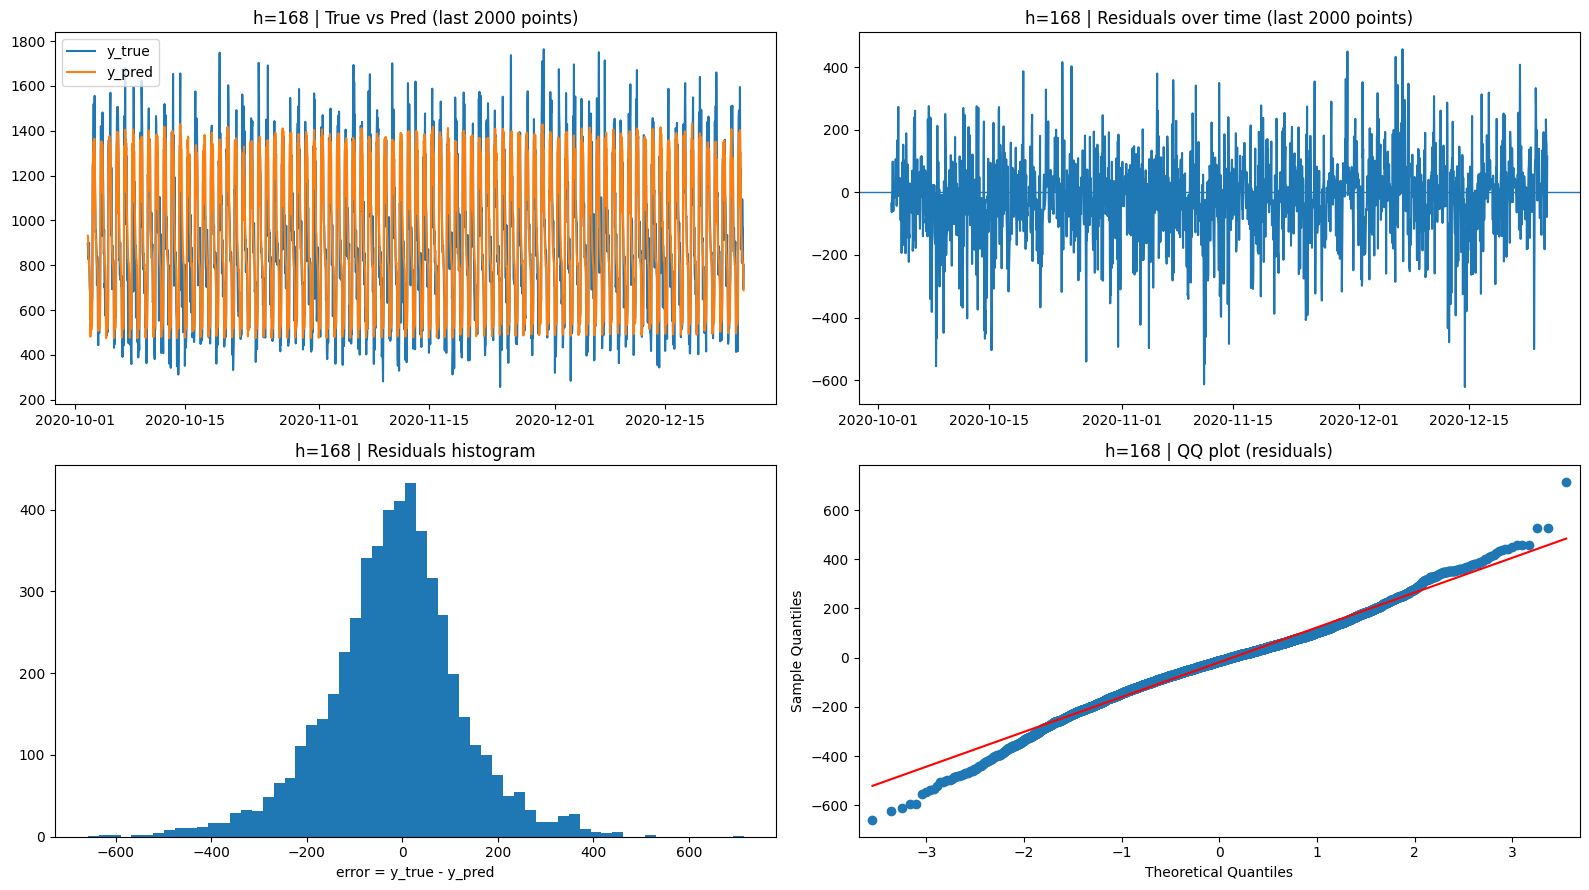

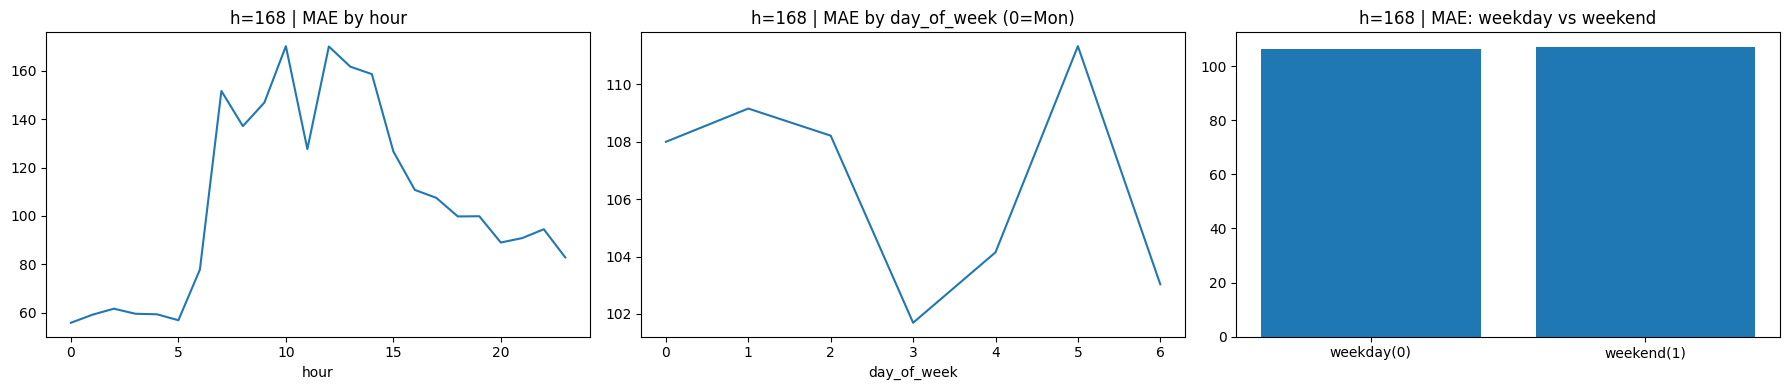

,horizon,test_MAE,test_RMSE,bias_mean_error,n_test
0,1,102.558044,136.765839,-12.064408,5235
1,24,108.251228,144.760101,-17.990616,5232
2,168,106.507126,142.775024,-18.812233,5210


,start,end,rolling_MAE_24h,horizon
0,2020-08-03 08:00:00,2020-08-04 07:00:00,198.662678,1
1,2020-08-03 09:00:00,2020-08-04 08:00:00,194.046734,1
2,2020-08-03 06:00:00,2020-08-04 05:00:00,190.135820,1
3,2020-08-03 11:00:00,2020-08-04 10:00:00,189.443007,1
4,2020-08-03 12:00:00,2020-08-04 11:00:00,188.576939,1
5,2020-08-03 07:00:00,2020-08-04 06:00:00,187.807418,1
6,2020-08-03 10:00:00,2020-08-04 09:00:00,186.011824,1
7,2020-08-03 13:00:00,2020-08-04 12:00:00,183.104748,1
8,2020-08-03 05:00:00,2020-08-04 04:00:00,183.014381,1
9,2020-08-03 01:00:00,2020-08-04 00:00:00,181.945109,1


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.gofplots import qqplot



def _make_pred_df(y_true: pd.Series, y_pred, ensure_datetime_index: bool = True) -> pd.DataFrame:
    """
    Собирает DF с ошибками.
    Требует, чтобы y_true был pd.Series с индексом времени (желательно DatetimeIndex).
    """
    if not isinstance(y_true, pd.Series):
        raise TypeError("y_true должен быть pd.Series (с индексом времени).")

    y_pred = pd.Series(np.asarray(y_pred).ravel(), index=y_true.index, name="y_pred")

    df_pred = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    df_pred["error"] = df_pred["y_true"] - df_pred["y_pred"]
    df_pred["abs_error"] = df_pred["error"].abs()
    df_pred["sq_error"] = df_pred["error"] ** 2

    if ensure_datetime_index and not isinstance(df_pred.index, pd.DatetimeIndex):
        raise TypeError(
            "Для календарных графиков индекс должен быть DatetimeIndex. "
            "Сейчас индекс: "
            f"{type(df_pred.index)}"
        )

    return df_pred


def _print_error_summary(df_pred: pd.DataFrame, label: str = ""):
    mae = df_pred["abs_error"].mean()
    rmse = np.sqrt(df_pred["sq_error"].mean())
    bias = df_pred["error"].mean()
    med_ae = df_pred["abs_error"].median()
    p90_ae = df_pred["abs_error"].quantile(0.90)
    p95_ae = df_pred["abs_error"].quantile(0.95)

    print(f"{label} MAE={mae:.2f}, RMSE={rmse:.2f}, bias(mean error)={bias:.2f}")
    print(f"{label} median_AE={med_ae:.2f}, p90_AE={p90_ae:.2f}, p95_AE={p95_ae:.2f}")


def _plot_basic_diagnostics(df_pred: pd.DataFrame, title_prefix: str = "", max_points: int = 2000):
    """
    1) факт vs прогноз (последний отрезок)
    2) остатки во времени (последний отрезок)
    3) histogram ошибок (на ВСЁМ test)
    4) QQ plot (на ВСЁМ test)
    """
    dfp = df_pred.iloc[-max_points:].copy() if len(df_pred) > max_points else df_pred.copy()

    fig, axes = plt.subplots(2, 2, figsize=(16, 9))

    axes[0, 0].plot(dfp.index, dfp["y_true"].values, label="y_true")
    axes[0, 0].plot(dfp.index, dfp["y_pred"].values, label="y_pred")
    axes[0, 0].set_title(f"{title_prefix} True vs Pred (last {len(dfp)} points)")
    axes[0, 0].legend()

    axes[0, 1].plot(dfp.index, dfp["error"].values)
    axes[0, 1].axhline(0, linewidth=1)
    axes[0, 1].set_title(f"{title_prefix} Residuals over time (last {len(dfp)} points)")

    axes[1, 0].hist(df_pred["error"].values, bins=60)
    axes[1, 0].set_title(f"{title_prefix} Residuals histogram")
    axes[1, 0].set_xlabel("error = y_true - y_pred")

    qqplot(df_pred["error"].values, line="s", ax=axes[1, 1])
    axes[1, 1].set_title(f"{title_prefix} QQ plot (residuals)")

    plt.tight_layout()
    plt.show()


def _plot_error_by_time_parts(df_pred: pd.DataFrame, title_prefix: str = ""):
    """
    Ошибки по календарным срезам:
    - по часу
    - по дню недели
    - выходной/будний
    Требует DatetimeIndex.
    """
    if not isinstance(df_pred.index, pd.DatetimeIndex):
        raise TypeError("df_pred.index должен быть DatetimeIndex для календарных графиков.")

    tmp = df_pred.copy()
    idx = tmp.index

    tmp["hour"] = idx.hour
    tmp["day_of_week"] = idx.dayofweek
    tmp["is_weekend"] = idx.dayofweek.isin([5, 6]).astype(int)

    by_hour = tmp.groupby("hour")["abs_error"].mean()
    by_dow = tmp.groupby("day_of_week")["abs_error"].mean()
    by_weekend = tmp.groupby("is_weekend")["abs_error"].mean()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    axes[0].plot(by_hour.index, by_hour.values)
    axes[0].set_title(f"{title_prefix} MAE by hour")
    axes[0].set_xlabel("hour")

    axes[1].plot(by_dow.index, by_dow.values)
    axes[1].set_title(f"{title_prefix} MAE by day_of_week (0=Mon)")
    axes[1].set_xlabel("day_of_week")

    axes[2].bar(["weekday(0)", "weekend(1)"], by_weekend.values)
    axes[2].set_title(f"{title_prefix} MAE: weekday vs weekend")

    plt.tight_layout()
    plt.show()


def _worst_intervals(df_pred: pd.DataFrame, window: int = 24, top_k: int = 10) -> pd.DataFrame:
    """
    Худшие интервалы по rolling mean abs_error длиной window.
    Интерпретация "window часов" корректна, если шаг данных = 1 час.
    """
    s = df_pred["abs_error"].rolling(window).mean()
    worst = s.sort_values(ascending=False).head(top_k)

    out = pd.DataFrame({
        "start": worst.index - pd.to_timedelta(window - 1, unit="h"),
        "end": worst.index,
        f"rolling_MAE_{window}h": worst.values
    })
    return out


# ===================== 2) MAIN =====================

def error_analysis_multi_horizon_from_splits(
    splits: dict,               # {h: (X_train, y_train, X_val, y_val, X_test, y_test)}
    final_models: dict,         # {h: model}
    horizons=(1, 24, 168),
    plot: bool = True,
    max_points_plot: int = 2000,
    worst_window: int = 24,
    worst_top_k: int = 10,
):
    """
    Анализ ошибок на TEST по новой логике:
    - НЕ строит features/targets/splits
    - НЕ делает time_split внутри
    - использует только готовые splits и готовые финальные модели

    Возвращает:
      preds: dict[h] -> df_pred (y_true, y_pred, error, abs_error, sq_error)
      summary: DataFrame (test MAE/RMSE/bias, n_test)
      worst: DataFrame (худшие окна) + horizon
    """
    preds = {}
    summary_rows = []
    worst_tables = []

    # нормализуем ключи final_models: на случай если где-то были "1" строкой
    fm = {int(k): v for k, v in final_models.items()}

    for h in horizons:
        h = int(h)

        if h not in splits:
            raise KeyError(f"splits не содержит горизонт h={h}. keys={list(splits.keys())}")

        if h not in fm:
            raise KeyError(f"final_models не содержит модель для h={h}. keys={list(fm.keys())}")

        X_train, y_train, X_val, y_val, X_test, y_test = splits[h]
        model = fm[h]

        # прогноз на test
        y_pred_test = model.predict(X_test)

        # df с ошибками
        df_pred = _make_pred_df(y_true=y_test, y_pred=y_pred_test, ensure_datetime_index=plot)
        preds[h] = df_pred

        mae = df_pred["abs_error"].mean()
        rmse = np.sqrt(df_pred["sq_error"].mean())
        bias = df_pred["error"].mean()

        summary_rows.append({
            "horizon": h,
            "test_MAE": mae,
            "test_RMSE": rmse,
            "bias_mean_error": bias,
            "n_test": len(df_pred)
        })

        print(f"\n=== Error analysis (TEST): h={h} ===")
        _print_error_summary(df_pred, label=f"h={h} |")

        if plot:
            _plot_basic_diagnostics(df_pred, title_prefix=f"h={h} |", max_points=max_points_plot)
            _plot_error_by_time_parts(df_pred, title_prefix=f"h={h} |")

        worst_df = _worst_intervals(df_pred, window=worst_window, top_k=worst_top_k)
        worst_df["horizon"] = h
        worst_tables.append(worst_df)

    summary = pd.DataFrame(summary_rows).sort_values("horizon").reset_index(drop=True)
    worst_all = pd.concat(worst_tables, ignore_index=True) if worst_tables else pd.DataFrame()

    return preds, summary, worst_all


# ===================== 3) EXAMPLE RUN =====================
preds, summary, worst = error_analysis_multi_horizon_from_splits(
    splits=splits,
    final_models=final_pack_xgb["final_models"],
    horizons=(1, 24, 168),
    plot=True
)
display(summary)
display(worst)

In [21]:
def get_feature_importance_xgb(model, feature_names, top_k=10):
    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": model.feature_importances_
    })

    fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)
    return fi, fi.head(top_k)

In [25]:
feature_names = X.columns

for h, model in final_pack_xgb["final_models"].items():
    fi_all, fi_top10 = get_feature_importance_xgb(model, feature_names, top_k=10)

    print(f"\nFeature importance | h={h}")
    display(fi_top10)


Feature importance | h=1


,feature,importance
0,lag_23,0.418680
1,lag_22,0.157908
2,lag_15,0.091844
3,hour,0.067282
4,lag_7,0.041585
5,lag_168,0.036859
6,lag_14,0.018796
7,lag_1,0.017179
8,lag_16,0.016943
9,lag_4,0.011162



Feature importance | h=24


,feature,importance
0,lag_168,0.272291
1,lag_24,0.175104
2,lag_48,0.173628
3,hour,0.062454
4,lag_16,0.061627
5,lag_8,0.049897
6,lag_9,0.028883
7,lag_23,0.027148
8,lag_15,0.021320
9,lag_1,0.021316



Feature importance | h=168


,feature,importance
0,lag_24,0.347036
1,lag_48,0.191179
2,lag_168,0.159720
3,hour,0.141137
4,lag_8,0.021820
5,lag_16,0.016775
6,lag_23,0.008404
7,lag_5,0.006904
8,lag_1,0.006769
9,lag_9,0.006718


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_daily_forecast_24h(
    splits: dict,
    final_models: dict,
    start_idx: int = 0,
    target_col: str = "Usage_kWh",
    title: str = "Прогноз на 24 часа"
):
    """
    Визуализация прогноза на 24 часа (1 сутки).
    """

    h = 24

    # --- данные и модель ---
    X_train, y_train, X_val, y_val, X_test, y_test = splits[h]
    model = final_models[h]

    # --- выбираем одну стартовую точку ---
    X_24h = X_test.iloc[start_idx:start_idx + 24]
    y_true_24h = y_test.iloc[start_idx:start_idx + 24]

    # защита
    if len(X_24h) < 24:
        raise ValueError("Недостаточно данных в test для 24 часов")

    # --- прогноз ---
    y_pred_24h = model.predict(X_24h)

    # --- индекс времени ---
    time_index = y_true_24h.index

    # --- график ---
    plt.figure(figsize=(12, 4))
    plt.plot(time_index, y_true_24h.values, label="Факт", marker="o")
    plt.plot(time_index, y_pred_24h, label="Прогноз", marker="s")

    plt.title(title)
    plt.xlabel("Время")
    plt.ylabel("Потребление, кВт·ч")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

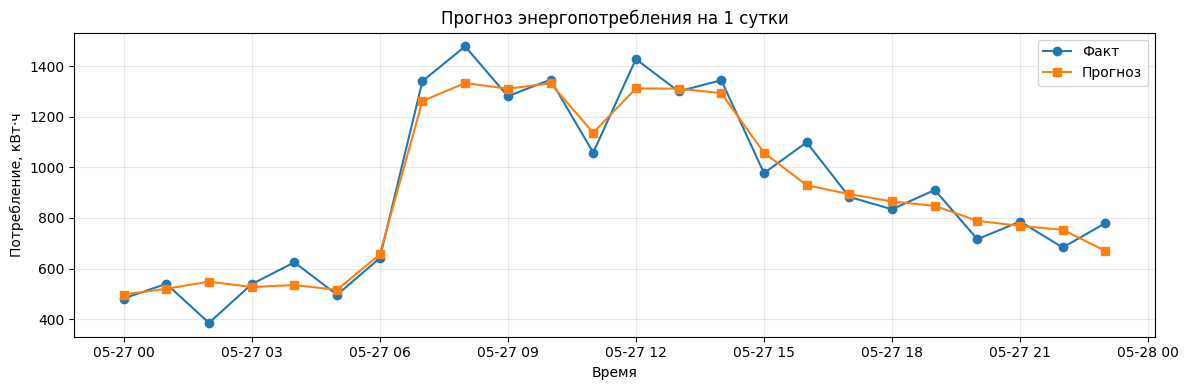

In [31]:
plot_daily_forecast_24h(
    splits=splits,
    final_models=final_pack_xgb["final_models"],
    start_idx=0,
    title="Прогноз энергопотребления на 1 сутки"
)

In [33]:
import matplotlib.pyplot as plt
import numpy as np


def plot_weekly_forecast_168h(
    splits: dict,
    final_models: dict,
    start_idx: int = 0,
    target_col: str = "Usage_kWh",
    title: str = "Прогноз на 168 часов (1 неделя)"
):
    h = 168

    X_train, y_train, X_val, y_val, X_test, y_test = splits[h]
    model = final_models[h]

    X_168h = X_test.iloc[start_idx:start_idx + 168]
    y_true_168h = y_test.iloc[start_idx:start_idx + 168]

    if len(X_168h) < 168:
        raise ValueError("Недостаточно данных в test для 168 часов")

    y_pred_168h = model.predict(X_168h)

    time_index = y_true_168h.index

    plt.figure(figsize=(14, 4))
    plt.plot(time_index, y_true_168h.values, label="Факт")
    plt.plot(time_index, y_pred_168h, label="Прогноз")

    plt.title(title)
    plt.xlabel("Время")
    plt.ylabel("Потребление, кВт·ч")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

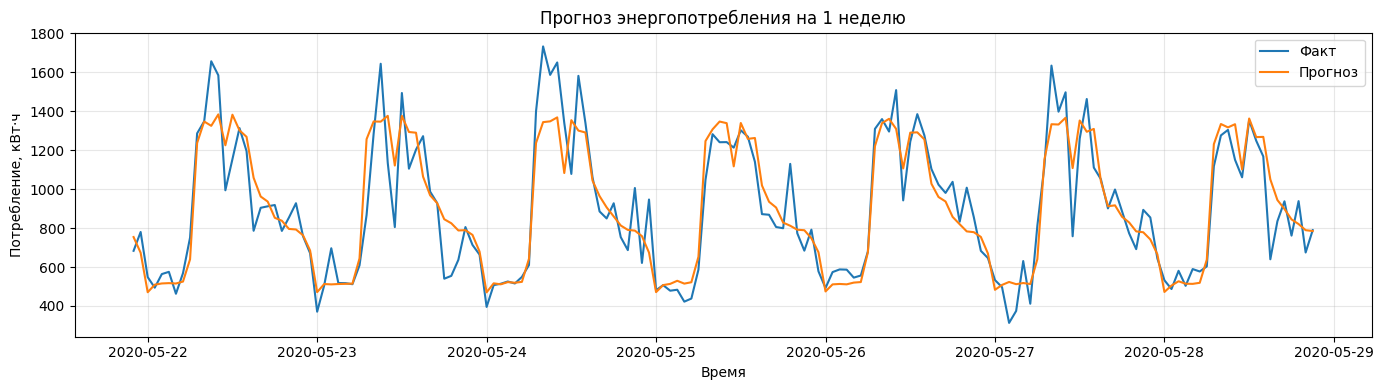

In [37]:
plot_weekly_forecast_168h(
    splits=splits,
    final_models=final_pack_xgb["final_models"],
    start_idx=0,
    title="Прогноз энергопотребления на 1 неделю"
)

In [39]:
PROJECT_ROOT = Path.cwd().parent
WEIGHTS_DIR = PROJECT_ROOT / "artifacts" / "weights"
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)
final_models = final_pack_xgb["final_models"]

for h, model in final_models.items():
    model_path = WEIGHTS_DIR / f"xgb_final_h{h}.joblib"
    joblib.dump(model, model_path)
    print(f"Saved model for horizon {h}: {model_path.resolve()}")

Saved model for horizon 1: /Users/alice/Desktop/EnergyForecast/artifacts/weights/xgb_final_h1.joblib
Saved model for horizon 24: /Users/alice/Desktop/EnergyForecast/artifacts/weights/xgb_final_h24.joblib
Saved model for horizon 168: /Users/alice/Desktop/EnergyForecast/artifacts/weights/xgb_final_h168.joblib


In [41]:
final_pack_xgb.keys()

dict_keys(['meta', 'summary', 'final_models'])